In [131]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import nltk
import re
import pickle
import string
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, LSTM
from keras.layers.core import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [51]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [91]:
# Reading Data
cols = ['sentiment','id','date','query_string','user','text'] #Defining the columns
df = pd.read_csv("/content/drive/My Drive/tweets.csv",header=None, encoding = 'latin-1', names = cols)

In [92]:
# Dropping unnecessary columns and converitng 4 label to 1 in order to ease
df.drop(columns = ['id','date','query_string','user'], axis=1, inplace=True)
df['sentiment'] = df['sentiment'].replace(4, 1)

In [93]:
# check the number of positive vs. negative tagged sentences
positives = df['sentiment'][df.sentiment == 1 ]
negatives = df['sentiment'][df.sentiment == 0 ]

print('Total length of the data is:         {}'.format(df.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         1600000
No. of positve tagged sentences is:  800000
No. of negative tagged sentences is: 800000


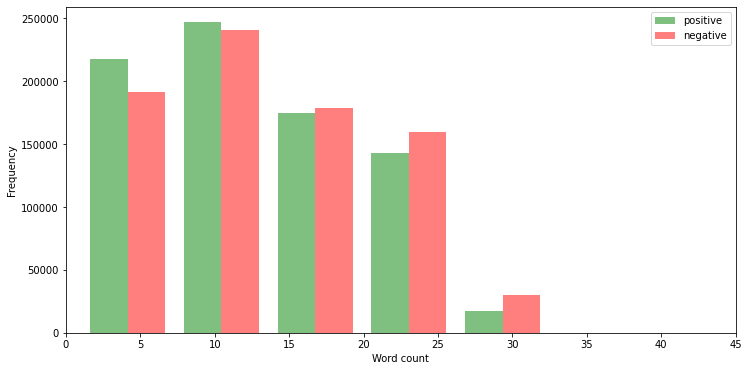

In [90]:
def word_count(words):
    return len(words.split())

# plot word count distribution for both positive and negative 

df['word count'] = df['text'].apply(word_count)
p = df['word count'][df.sentiment == 1]
n = df['word count'][df.sentiment == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [49]:
df.text[400].translate(str.maketrans("","",string.punctuation))

'3 woke up and was having an accident  quotIts pushing its pushingquot he was crying because he couldnt stop from wetting his pants  '

In [121]:
def tweet_cleaner(text):
  urlPattern = r'http://[^ ]*|https://[^ ]*|www\.[^ ]*'
  userPattern = '@[^\s]+'
  hashtag_number = '[#0-9]+'
  soup = BeautifulSoup(text, 'lxml')
  souped = soup.get_text()
  # Removing all URls 
  tweet = re.sub(urlPattern,'',str(souped).lower()).strip()
  # Removing all @username.
  tweet = re.sub(userPattern,'', tweet) 
  # Removing all hashtag-numbers.
  tweet = re.sub(hashtag_number,'', tweet) 
  tweet = re.sub('(?<=.)[\'](?=.)', ' ', tweet)
  tweet = re.sub('((?<=^)|(?<=\s)).((?=$)|(?=\s))', '', tweet)
  tweet = re.sub('([^ ]*)(\.com)', '', tweet)
  tweet = tweet.translate(str.maketrans("","",string.punctuation))
  #tokenizing words
  tokens = word_tokenize(tweet)
  #Removing Stop Words
  final_tokens = [w for w in tokens if w not in stopword]
  #reducing a word to its word stem 
  wordLemm = WordNetLemmatizer()
  finalwords=[]
  for w in final_tokens:
     if len(w)>1:
      word = wordLemm.lemmatize(w)
      finalwords.append(word)
  return ' '.join(finalwords)

In [122]:
df['processed_tweets'] = df['text'].apply(tweet_cleaner)
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [127]:
df = df.drop(columns = ['text']).rename(columns = {'processed_tweets' : 'text'})

In [135]:
#df.to_csv('clean_tweet.csv',encoding='utf-8')
#csv = 'clean_tweet.csv'
#my_df = pd.read_csv(csv,index_col=0)

In [132]:
all_words = []
for line in list(df['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(20)

[('day', 104653),
 ('good', 89797),
 ('get', 86085),
 ('like', 79183),
 ('got', 69864),
 ('love', 67336),
 ('work', 66613),
 ('today', 66195),
 ('going', 64140),
 ('time', 64022),
 ('back', 56213),
 ('one', 56089),
 ('lol', 55344),
 ('know', 53412),
 ('really', 49588),
 ('want', 48314),
 ('see', 46135),
 ('night', 44154),
 ('think', 43536),
 ('still', 42868)]

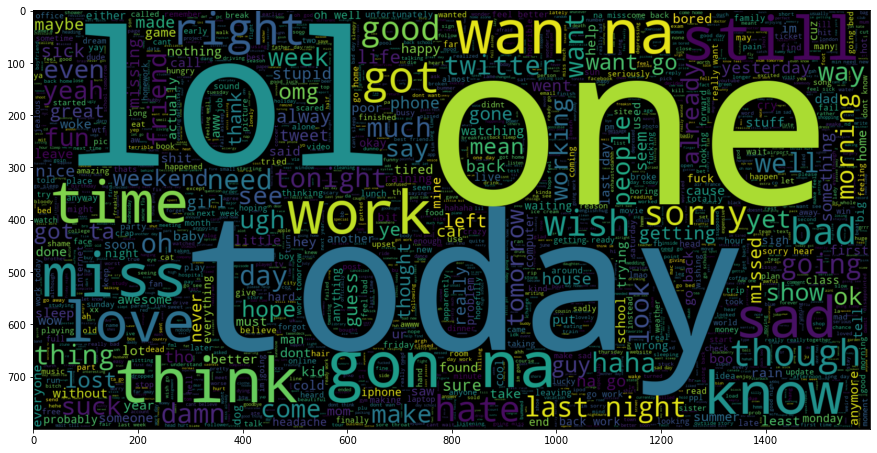

In [133]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

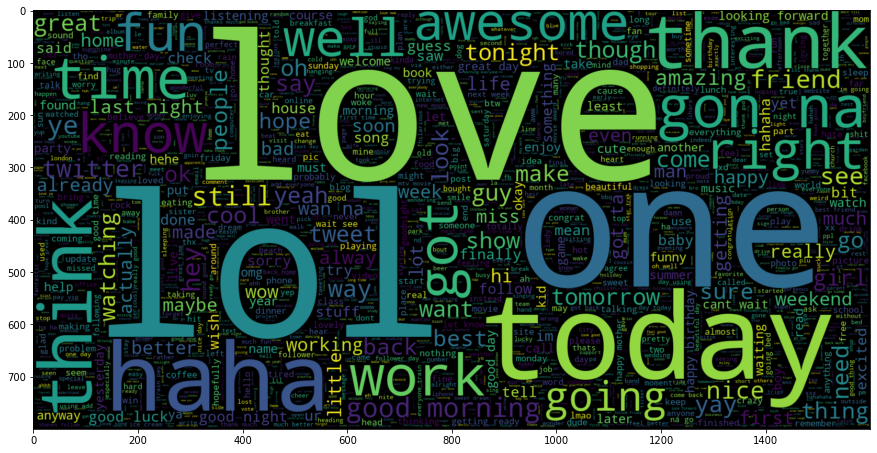

In [134]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')